<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Progress_Barometer5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for GDP per capita (current US$)...
Fetching data for Human Development Index (HDI)...
Fetching data for Governance Effectiveness...

Countries with missing values:
['AFE', 'AFW', 'AND', 'ARB', 'ASM', 'CEB', 'CHI', 'CSS', 'CUW', 'CYM', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU', 'ERI', 'EUU', 'FCS', 'FRO', 'GIB', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX', 'IMN', 'LAC', 'LCN', 'LDC', 'LMY', 'LTE', 'MAF', 'MCO', 'MEA', 'MIC', 'MNA', 'MNP', 'NAC', 'NCL', 'OED', 'OSS', 'PLW', 'PRE', 'PRK', 'PSS', 'PST', 'PYF', 'SAS', 'SMR', 'SSA', 'SSD', 'SSF', 'SST', 'SXM', 'TCA', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA', 'TSS', 'VEN', 'VGB', 'WLD']
Filled 0 missing values in GDP per capita (current US$) with median: 6247.596924496405
Filled 0 missing values in Human Development Index (HDI) with median: 72.677
Filled 0 missing values in Governance Effectiveness with median: -0.126768589019775

Portugal data:
    Country  GDP per capita (current US$)  Human Development Index (HDI)  \
190     PRT       

<ipython-input-3-baa0131ae252>:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  progress_data[column].fillna(median_value, inplace=True)


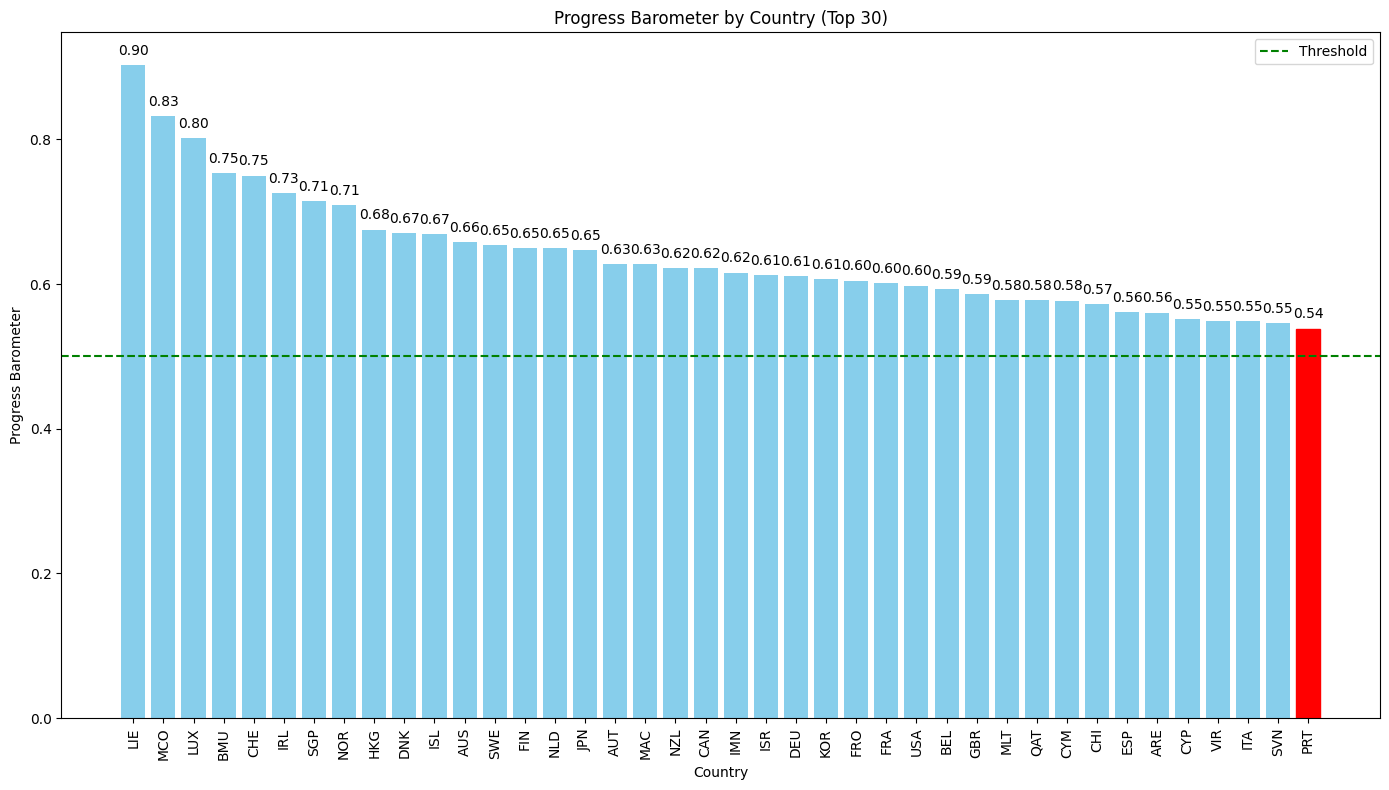


Full results saved to 'progress_barometer_results.csv'


In [ ]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define a function to fetch data from the World Bank API
def fetch_world_bank_data(indicator, countries="all", date="2020", format="json"):
    base_url = "http://api.worldbank.org/v2"
    url = f"{base_url}/country/{countries}/indicator/{indicator}?date={date}&format={format}&per_page=1000"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if len(data) > 1:  # Check if data is available
            return data[1]  # Return the actual data part of the response
        else:
            print(f"No data available for indicator {indicator}")
            return None
    else:
        print(f"Failed to fetch data for indicator {indicator}. Status code: {response.status_code}")
        return None

# Define indicators for the composite index
indicators = {
    "GDP per capita (current US$)": "NY.GDP.PCAP.CD",
    "Human Development Index (HDI)": "SP.DYN.LE00.IN",  # Example proxy using life expectancy
    "Governance Effectiveness": "GE.EST"  # Replace with an actual governance indicator if available
}

# Fetch data for each indicator
data_frames = []
for name, code in indicators.items():
    print(f"Fetching data for {name}...")
    data = fetch_world_bank_data(code)
    if data:
        df = pd.DataFrame(data)
        # Check if data has the required columns
        if "countryiso3code" in df.columns and "value" in df.columns:
            # Filter out rows where countryiso3code is empty
            df = df[df["countryiso3code"] != ""]
            df = df[["countryiso3code", "value"]].rename(columns={"countryiso3code": "Country", "value": name})
            data_frames.append(df)
        else:
            print(f"Missing required columns in data for {name}")

# Merge all indicators into a single DataFrame
if len(data_frames) > 1:
    progress_data = pd.merge(data_frames[0], data_frames[1], on="Country", how="outer")
    for i in range(2, len(data_frames)):
        progress_data = pd.merge(progress_data, data_frames[i], on="Country", how="outer")

    # Print countries with missing values to help identify issues
    missing_values = progress_data[progress_data.isna().any(axis=1)]
    if not missing_values.empty:
        print("\nCountries with missing values:")
        print(missing_values["Country"].tolist())

    # Instead of dropping rows with missing values, fill them with median or mean
    for column in indicators.keys():
        progress_data[column] = pd.to_numeric(progress_data[column], errors='coerce')
        median_value = progress_data[column].median()
        progress_data[column].fillna(median_value, inplace=True)
        print(f"Filled {progress_data[column].isna().sum()} missing values in {column} with median: {median_value}")

    # Look specifically for Portugal
    if "PRT" in progress_data["Country"].values:
        print("\nPortugal data:")
        print(progress_data[progress_data["Country"] == "PRT"])
    else:
        print("\nPortugal not found in the dataset. Check if it's labeled differently.")

    # Normalize the indicators (0-1 scale)
    for column in indicators.keys():
        min_val = progress_data[column].min()
        max_val = progress_data[column].max()
        if max_val > min_val:  # Avoid division by zero
            progress_data[column] = (progress_data[column] - min_val) / (max_val - min_val)
        else:
            progress_data[column] = 0  # If all values are the same

    # Calculate the Progress Barometer index (weighted average)
    weights = {"GDP per capita (current US$)": 0.4, "Human Development Index (HDI)": 0.4, "Governance Effectiveness": 0.2}
    progress_data["Progress Barometer"] = sum(progress_data[col] * weight for col, weight in weights.items())

    # Set a threshold for progress readiness
    threshold = 0.5
    progress_data["Progress Ready"] = progress_data["Progress Barometer"] > threshold

    # Display top 10 and bottom 10 countries
    print("\nTop 10 countries by Progress Barometer:")
    print(progress_data.sort_values("Progress Barometer", ascending=False).head(10)[["Country", "Progress Barometer", "Progress Ready"]])
    print("\nBottom 10 countries by Progress Barometer:")
    print(progress_data.sort_values("Progress Barometer").head(10)[["Country", "Progress Barometer", "Progress Ready"]])

    # Limit to top 30 countries for better readability in the chart
    top_countries = progress_data.sort_values("Progress Barometer", ascending=False).head(40)

    # Visualize the Progress Barometer
    plt.figure(figsize=(14, 8))
    bars = plt.bar(top_countries["Country"], top_countries["Progress Barometer"], color="skyblue")

    # If Portugal is in the top 30, highlight it
    if "PRT" in top_countries["Country"].values:
        portugal_idx = top_countries[top_countries["Country"] == "PRT"].index[0]
        portugal_pos = top_countries.index.get_loc(portugal_idx)
        bars[portugal_pos].set_color("red")

    plt.axhline(y=threshold, color="green", linestyle="--", label="Threshold")
    plt.xlabel("Country")
    plt.ylabel("Progress Barometer")
    plt.title("Progress Barometer by Country (Top 30)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()

    # Add country labels above the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f"{height:.2f}", ha='center', va='bottom', rotation=0)

    plt.show()

    # Save full results to CSV for further analysis
    progress_data.to_csv("progress_barometer_results.csv", index=False)
    print("\nFull results saved to 'progress_barometer_results.csv'")
else:
    print("Not enough data to calculate the Progress Barometer.")